In [ ]:
!pip install torchextractor

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
  Using cached nvidia_nvjitlink_cu12-12.4.127-py3-none-m

In [ ]:
import torch
import sys
import numpy as np
import pickle as pkl
from os.path import join as oj
from datetime import datetime
import torch.optim as optim
import os
from torch.utils.data import TensorDataset, ConcatDataset
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc, f1_score
import argparse
from PIL import Image
from tqdm import tqdm
from torch import nn
from numpy.random import randint
import torchvision.models as models
import time
import copy
import gc
import json
import pandas as pd
import torch
import torchvision.models as models
from torchvision import transforms
from PIL import Image

## Mount Google Drive and create paths for directories

In [ ]:
from google.colab import drive
drive.mount("/content/drive")
dir_path = "/content/drive/MyDrive/Masterthesis/Datasets/ISIC_224"
#dir_path = "/content/drive/MyDrive/Projects/ISIC_224"

Mounted at /content/drive


In [ ]:
model_path = oj(dir_path, "models", "initial_classifier")
model_training_path = oj(model_path, "training_224")
data_path = oj(dir_path, "data")

not_cancer_path = oj(data_path, "processed", "no_cancer_224")
cancer_path = oj(data_path, "processed", "cancer_224")

## Arguments for training

1. Mean and Standard Deviation: These are normalization parameters used for preprocessing images. They are often used in computer vision tasks to scale pixel values to a common range.

2. Device Configuration: It determines whether the code should run on CPU or GPU (cuda) based on the availability of CUDA support. CUDA is a parallel computing platform and application programming interface model created by NVIDIA. If CUDA is available, the code will run on the GPU; otherwise, it will use the CPU.

3. Model Initialization: It loads a pre-trained VGG16 model from torchvision.models, modifies the last layer of the classifier to output 2 classes (it seems to be for some kind of classification task), moves the model to the specified device (CPU or GPU), and sets the parameters to update during training (in this case, only the parameters of the classifier).

❗❗❗*params_to_update = model.classifier.parameters(): This specifies the parameters of the model that will be updated during training. In this case, it selects only the parameters of the classifier, excluding the parameters of the feature extractor.*

In [ ]:
import numpy as np
import argparse
import torch
import torchvision.models as models
import torch.nn as nn

mean = np.asarray([0.485, 0.456, 0.406])
std = np.asarray([0.229, 0.224, 0.225])

# Define arguments
class Args:
    def __init__(self):
        self.batch_size = 16
        self.epochs = 10
        self.lr = 0.00001
        self.momentum = 0.9
        self.seed = 42
        self.regularizer_rate = 0.0

args = Args()

regularizer_rate = args.regularizer_rate
num_epochs = args.epochs
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

torch.manual_seed(args.seed)

#model = models.vgg16(pretrained=True)
model = models.alexnet(pretrained=True)

model.classifier[-1] = nn.Linear(4096, 2)
model = model.to(device)
params_to_update = model.classifier.parameters()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:02<00:00, 101MB/s]


## Clean up the image directories

*   Remove empty images
*   Remove duplicates which appear in a new folder but not the original.
*   Ensure image sizes are all 224x224

In [ ]:
def clean_up_empty_files(path):
    list_files= os.listdir(path)
    num_files = len(list_files)
    for i in tqdm(range(num_files)):
        if os.path.getsize(oj(path, list_files[i])) < 100:
            os.remove(oj(path, list_files[i]))
            print("File " + str(i) + "deleted!")
'''
def clean_up_duplicates(path1, path2):
    newfiles = os.listdir(path1)
    oldfiles = os.listdir(path2)
    diff = [f for f in newfiles if f not in oldfiles]
    for i in tqdm(diff):
        os.remove(oj(path1, i))
        print("File " + str(i) + "deleted!")

def check_img_sizes(path):
    list_files= os.listdir(path)
    num_files = len(list_files)
    for i in tqdm(range(num_files)):
        im = Image.open(oj(path, list_files[i]))
        if im.width != 224 or im.height != 224:
            print(list_files[i])
'''
# clean_up_empty_files(cancer_path)
# clean_up_empty_files(not_cancer_path)

# newpath = oj(data_path, "no_cancer_224_inpainted")
# oldpath = oj(data_path, "processed", "no_cancer_224")
# clean_up_duplicates(newpath, oldpath)

# check_img_sizes(not_cancer_path)


'\ndef clean_up_duplicates(path1, path2):\n    newfiles = os.listdir(path1)\n    oldfiles = os.listdir(path2)\n    diff = [f for f in newfiles if f not in oldfiles]\n    for i in tqdm(diff):\n        os.remove(oj(path1, i))\n        print("File " + str(i) + "deleted!")\n\ndef check_img_sizes(path):\n    list_files= os.listdir(path)\n    num_files = len(list_files)\n    for i in tqdm(range(num_files)):\n        im = Image.open(oj(path, list_files[i]))\n        if im.width != 224 or im.height != 224:\n            print(list_files[i])\n'

### Torch dataset class
**Purpose**:
Defines a custom dataset class for handling cancer image data in PyTorch.
Key Components:

**Class Definition**:
CancerDataset inherits from torch.utils.data.Dataset.

Initialization `(__init__ method)`:
*   Sets up the dataset.
*   Accepts two ways of specifying data:
    1. By Directory: Provide directory path and a label.
    2. By Filepaths and Labels: Provide list of file paths and corresponding labels.






Get Item `(__getitem__ method)`:
*   Loads and processes an image.
*   Converts image to numpy array, scales pixel values to [0, 1].
*   Standardizes the image.
*   Converts the image to a PyTorch tensor.
*   Returns the image tensor and label.


Length `(__len__ method)`:
*   Returns the total number of images in the dataset.




**Workflow**:
1. Initialization: Create an instance of CancerDataset.
2. DataLoader: Use DataLoader to load data in batches, shuffle, and handle multi-threaded loading.
3. Training: Iterate over DataLoader in the training loop.

In [ ]:
class CancerDataset(torch.utils.data.Dataset):
    def __init__(self, path: str = None, is_cancer: int = None, data_files = None, labels = None):
        """
        Expects path and is_cancer both to be supplied if the relevant images all lie in the same directory and have the same class
        or a list of full filepaths and list of all labels are both supplied using data_files and labels otherwise.
        """
        if path:
            self.path = path
            self.data_files = os.listdir(self.path)
            self.is_cancer = is_cancer

        else:
            self.path = ''
            self.data_files = data_files
            self.labels = labels
            self.is_cancer = None

    def __getitem__(self, i):
        # Read in the image from the specified path and convert it to a float array with values between [0, 1]
        img = Image.open(os.path.join(self.path, self.data_files[i]))
        img_array = np.asarray(img) / 255.0

        # Standardize the image by subtracting the mean and dividing by the standard deviation
        img_array -= mean[None, None, :]  # mean and std should be defined elsewhere in the code
        img_array /= std[None, None, :]

        # Close the image to free up resources
        img.close()

        # Convert the numpy array to a PyTorch tensor
        # swapaxes(0, 2) and swapaxes(1, 2) rearrange the dimensions from (height, width, channels) to (channels, height, width)
        torch_img = torch.from_numpy(img_array.swapaxes(0, 2).swapaxes(1, 2)).float()

        # Determine the label for the image: use the global class label if provided,
        # otherwise, use the label from the labels list
        is_cancer = self.is_cancer if self.is_cancer is not None else self.labels[i]

        # Return the processed image tensor and its corresponding label
        return (torch_img, is_cancer)

    def __len__(self):
        return len(self.data_files)

###Functions for training

`gradient_sum`
calculates the sum of gradients of the loss with respect to the input image, which can be used for regularization in training.

`torch.autograd.grad` computes the gradients of the loss (defined by crit) with respect to the input image. The `model(im)` gives the model's output for the image, and target is the ground truth label.

`torch.abs(...).sum(dim=1)).sum()` computes the absolute values of the gradients, sums them along the first dimension, and then sums all of them together.


In [ ]:
def gradient_sum(im, target, model, crit, device='cuda'):
    '''Calculate the sum of gradients for regularization purposes.'''

    # Set requires_grad to True to enable gradient computation with respect to the input image
    im.requires_grad = True

    # Compute the gradient of the loss with respect to the input image
    grad_params = torch.abs(torch.autograd.grad(crit(model(im), target), im, create_graph=True)[0].sum(dim=1)).sum()

    # Return the sum of absolute gradients
    return grad_params

def train_model(model, dataloaders, criterion, optimizer, num_epochs=25, resume_training=False):
    '''Train the model using the specified parameters and data.'''

    since = time.time()  # Record the start time for training duration

    # Initialize training metrics and early stopping parameters
    best_loss = 10.0
    patience = 3
    cur_patience = 0

    # Check if there's a need to resume training from a saved model
    if len(os.listdir(model_training_path)) > 0 and resume_training:
        # Get a list of saved models sorted by modification time (most recent first)
        model_list = [(f, os.path.getmtime(os.path.join(model_training_path, f))) for f in os.listdir(model_training_path) if f.endswith('.pt')]
        model_list.sort(key=lambda tup: tup[1], reverse=True)

        # Load the most recent model checkpoint
        model_name = model_list[0][0]
        model.classifier.load_state_dict(torch.load(os.path.join(model_training_path, model_name)))
        print("Model loaded!")

    # Loop through each epoch
    for epoch in range(1, num_epochs + 1):
        print('Epoch {}/{}'.format(epoch, num_epochs))
        print('-' * 10)

        # Perform optimizer step (usually called after loss.backward())
        optimizer.step()

        # Set model to training mode
        model.train()
        phase = 'train'

        # Initialize running statistics
        running_loss = 0.0
        running_loss_cd = 0.0
        running_corrects = 0

        # Iterate over the data loader for the current phase (training)
        for i, (inputs, labels) in tqdm(enumerate(dataloaders[phase])):

            # Move inputs and labels to the specified device (e.g., GPU)
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Enable gradient calculation if in the training phase
            with torch.set_grad_enabled(phase == 'train'):

                # If using a regularizer, calculate the additional loss
                if phase == 'train' and regularizer_rate != 0:
                    inputs.requires_grad = True
                    add_loss = gradient_sum(inputs, labels, model, criterion)

                    # Backpropagate the additional loss if it's non-zero
                    if add_loss != 0:
                        (regularizer_rate * add_loss).backward()
                        optimizer.step()

                    # Zero the parameter gradients again
                    optimizer.zero_grad()

                    # Accumulate the additional loss
                    running_loss_cd += add_loss.item() * inputs.size(0)

                # Forward pass: compute model outputs and loss
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                # Backward pass and optimization step in training phase
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

            # Update running statistics
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        # Compute epoch statistics
        epoch_loss = running_loss / dataset_sizes[phase]
        epoch_cd_loss = running_loss_cd / dataset_sizes[phase]
        epoch_acc = running_corrects.double() / dataset_sizes[phase]

        # Print epoch statistics
        print('{} Loss: {:.4f} Acc: {:.4f} CD Loss : {:.4f}'.format(phase, epoch_loss, epoch_acc, epoch_cd_loss))

        # train_loss_history.append(epoch_loss)
        # train_cd_history.append(epoch_cd_loss)
        # train_acc_history.append(epoch_acc.item())

        # Save the model checkpoint with model name
        model_name = type(model).__name__
        checkpoint_name = f"{model_name}_{datetime.now().strftime('%Y%m%d%H%M%S')}.pt"
        torch.save(model.classifier.state_dict(), os.path.join(model_training_path, checkpoint_name))


    # Print the total training duration
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val loss: {:4f}'.format(best_loss))

    # Return the trained model
    return model


Functions for evaluation

In [ ]:
from sklearn.metrics import auc,average_precision_score, roc_curve,roc_auc_score,precision_recall_curve, f1_score

def get_output(model, dataset):
    data_loader = torch.utils.data.DataLoader(dataset, batch_size=16,
                                             shuffle=False, num_workers=2)
    model = model.eval()
    y = []
    y_hat = []
    softmax= torch.nn.Softmax()
    with torch.no_grad() :
        for inputs, labels in data_loader:
            y_hat.append((labels).cpu().numpy())
            y.append(torch.nn.Softmax(dim=1)( model(inputs.cuda()))[:,1].detach().cpu().numpy()) # take the probability for cancer
    y_hat = np.concatenate( y_hat, axis=0 )
    y = np.concatenate( y, axis=0 )
    return y, y_hat # in the training set the values were switched

def get_auc_f1(model, dataset,fname = None, ):
    if fname !=None:
        with open(fname, 'rb') as f:
            weights = torch.load(f)
        if "classifier.0.weight" in weights.keys(): #for the gradient models we unfortunately saved all of the weights
            model.load_state_dict(weights)
        else:
            model.classifier.load_state_dict(weights)
        y, y_hat = get_output(model.classifier, dataset)
    else:
        y, y_hat = get_output(model, dataset)
    auc =roc_auc_score(y_hat, y)
    f1 = np.asarray([f1_score(y_hat, y > x) for x in np.linspace(0.1,1, num = 10) if (y >x).any() and (y<x).any()]).max()
    return auc, f1

## Initial Classifier Training

Combine datasets and split to train-test

In [ ]:
cancer_dataset = CancerDataset(path=cancer_path, is_cancer=1)
not_cancer_dataset = CancerDataset(path=not_cancer_path, is_cancer=0)
complete_dataset = ConcatDataset((cancer_dataset, not_cancer_dataset))

num_total = len(complete_dataset)
num_train = int(0.8 * num_total)
num_test = num_total - num_train
torch.manual_seed(0);
print("num_train:", num_train)
print("num_test:", num_test)

train_dataset, test_dataset = torch.utils.data.random_split(complete_dataset, [num_train, num_test])
datasets = {'train' : train_dataset, 'test':test_dataset}
dataset_sizes = {'train' : len(train_dataset), 'test':len(test_dataset)}

dataloaders = {x: torch.utils.data.DataLoader(datasets[x], batch_size=args.batch_size,
                                             shuffle=True, num_workers=2)
              for x in ['train', 'test']}

num_train: 9340
num_test: 2336


Record the specific files in the training/test sets.


In [ ]:
def list_to_file(li, filename):
  with open(filename, 'w') as f:
    for item in li:
      f.write("%s\n" % item)

def extract_filenames(train_subset, test_subset):
  # Extract the relevant indices of the concat dataset
  train_idx, test_idx = train_subset.indices, test_subset.indices

  # Extract the filenames for the cancer_dataset and not_cancer_dataset and concatenate with their directory path.
  # Each original dataset is stored by the ConcatDataset class. So even though train_subset is a subset, the info for the whole cancer dataset is stored in train_subset.dataset.datasets[0]
  cancer_filepaths      = [oj(train_subset.dataset.datasets[0].path, file) for file in train_subset.dataset.datasets[0].data_files]
  not_cancer_filepaths  = [oj(train_subset.dataset.datasets[1].path, file) for file in train_subset.dataset.datasets[1].data_files]

  filepaths = cancer_filepaths + not_cancer_filepaths    # Append the lists together, this combined list is what the indices are based on.

  train_files = [filepaths[i] for i in train_idx]
  test_files  = [filepaths[i] for i in test_idx]

  return train_files, test_files

In [ ]:
# # Call the function and get the full file paths.
train_files, test_files = extract_filenames(train_dataset, test_dataset)
list_to_file(train_files, oj(dir_path, 'models', 'train_files.txt'))   # Write the training filepaths to a text file.
list_to_file(test_files,  oj(dir_path, 'models', 'test_files.txt'))    # Write the testing filepaths to a text file.

## Weights for training

Since the classes are unbalanced, we need to account for this in the loss function while training

In [ ]:
cancer_ratio = len(cancer_dataset)/len(complete_dataset)

not_cancer_ratio = 1 - cancer_ratio
cancer_weight = 1/cancer_ratio
not_cancer_weight = 1/ not_cancer_ratio
weights = np.asarray([not_cancer_weight, cancer_weight])
weights /= weights.sum()
weights = torch.tensor(weights).to(device)

criterion = nn.CrossEntropyLoss(weight = weights.double().float())

optimizer_ft = optim.SGD(params_to_update, lr=args.lr, momentum=args.momentum)

Train and save the model

In [ ]:
model = train_model(model, dataloaders, criterion, optimizer_ft, num_epochs=num_epochs, resume_training=False)
pid = datetime.now().strftime('%Y%m%d%H%M%S')
torch.save(model.classifier.state_dict(),oj(dir_path, model_path, pid + ".pt"))

Epoch 1/10
----------


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
583it [09:01,  2.93it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
584it [09:01,  1.08it/s]


train Loss: 0.2821 Acc: 0.8679 CD Loss : 0.0000
Epoch 2/10
----------


584it [01:04,  9.08it/s]


train Loss: 0.2394 Acc: 0.8807 CD Loss : 0.0000
Epoch 3/10
----------


584it [01:03,  9.27it/s]


train Loss: 0.2296 Acc: 0.8828 CD Loss : 0.0000
Epoch 4/10
----------


584it [01:11,  8.20it/s]


train Loss: 0.2198 Acc: 0.8892 CD Loss : 0.0000
Epoch 5/10
----------


584it [01:05,  8.87it/s]


train Loss: 0.2151 Acc: 0.8892 CD Loss : 0.0000
Epoch 6/10
----------


584it [00:51, 11.44it/s]


train Loss: 0.2147 Acc: 0.8891 CD Loss : 0.0000
Epoch 7/10
----------


584it [01:01,  9.43it/s]


train Loss: 0.2096 Acc: 0.8974 CD Loss : 0.0000
Epoch 8/10
----------


584it [00:54, 10.80it/s]


train Loss: 0.2130 Acc: 0.8909 CD Loss : 0.0000
Epoch 9/10
----------


584it [00:50, 11.65it/s]


train Loss: 0.2121 Acc: 0.8934 CD Loss : 0.0000
Epoch 10/10
----------


584it [00:51, 11.28it/s]


train Loss: 0.2060 Acc: 0.8940 CD Loss : 0.0000
Training complete in 18m 7s
Best val loss: 10.000000


In [ ]:
auc, f1 = get_auc_f1(model, test_dataset)
print("AUC: ", auc)
print("F1: ", f1)


AUC:  0.9629055799238891
F1:  0.5358255451713395


In [ ]:

results_file_path = oj(dir_path, "auc_f1_224_no_malig_patch.txt")
print(results_file_path)
with open(results_file_path, 'w') as f:
    f.write('AUC: ' + str(auc) + "\n")
    f.write('F1: ' + str(f1) + "\n")

/content/drive/MyDrive/Masterthesis/Datasets/ISIC_224/auc_f1_224_no_malig_patch.txt


# Reload the model to skip retraining and test with patched images

In [ ]:
cancer_patch_path = '/content/drive/MyDrive/Masterthesis/Datasets/ISIC_224/malignant_patched_224'
not_cancer_path = '/content/drive/MyDrive/Masterthesis/Datasets/ISIC_224/data/processed/no_cancer_224'

In [ ]:
cancer_patch_dataset = CancerDataset(path=cancer_patch_path, is_cancer=1)
not_cancer_dataset = CancerDataset(path=not_cancer_path, is_cancer=0)
complete_patch_dataset = ConcatDataset((cancer_patch_dataset, not_cancer_dataset))

num_total = len(complete_patch_dataset)
num_train = int(0.8 * num_total)
num_test = num_total - num_train
torch.manual_seed(0);
print("num_train:", num_train)
print("num_test:", num_test)

train_patch_dataset, test_patch_dataset = torch.utils.data.random_split(complete_patch_dataset, [num_train, num_test])
datasets = {'train' : train_patch_dataset, 'test':test_patch_dataset}
dataset_sizes = {'train' : len(train_patch_dataset), 'test':len(test_patch_dataset)}

dataloaders = {x: torch.utils.data.DataLoader(datasets[x], batch_size=args.batch_size,
                                             shuffle=True, num_workers=2)
              for x in ['train', 'test']}

num_train: 9340
num_test: 2336


In [ ]:
def list_to_file(li, filename):
  with open(filename, 'w') as f:
    for item in li:
      f.write("%s\n" % item)

def extract_filenames(train_subset, test_subset):
  # Extract the relevant indices of the concat dataset
  train_idx, test_idx = train_subset.indices, test_subset.indices

  # Extract the filenames for the cancer_dataset and not_cancer_dataset and concatenate with their directory path.
  # Each original dataset is stored by the ConcatDataset class. So even though train_subset is a subset, the info for the whole cancer dataset is stored in train_subset.dataset.datasets[0]
  cancer_filepaths      = [oj(train_subset.dataset.datasets[0].path, file) for file in train_subset.dataset.datasets[0].data_files]
  not_cancer_filepaths  = [oj(train_subset.dataset.datasets[1].path, file) for file in train_subset.dataset.datasets[1].data_files]

  filepaths = cancer_filepaths + not_cancer_filepaths    # Append the lists together, this combined list is what the indices are based on.

  train_files = [filepaths[i] for i in train_idx]
  test_files  = [filepaths[i] for i in test_idx]

  return train_files, test_files

In [ ]:
# # Call the function and get the full file paths.
train_patch_files, test_patch_files = extract_filenames(train_patch_dataset, test_patch_dataset)
list_to_file(train_files, oj(dir_path, 'models', 'train_files.txt'))   # Write the training filepaths to a text file.
list_to_file(test_files,  oj(dir_path, 'models', 'test_files.txt'))    # Write the testing filepaths to a text file.

In [ ]:
def get_auc_f1(model, dataset,fname = None, ):
    if fname !=None:
        with open(fname, 'rb') as f:
            weights = torch.load(f)
        if "classifier.0.weight" in weights.keys(): #for the gradient models they saved all of the weights
            model.load_state_dict(weights)
        else:
            model.classifier.load_state_dict(weights)
        y, y_hat = get_output(model.classifier, dataset)
    else:
        y, y_hat = get_output(model, dataset)
    auc =roc_auc_score(y_hat, y)
    f1 = np.asarray([f1_score(y_hat, y > x) for x in np.linspace(0.1,1, num = 10) if (y >x).any() and (y<x).any()]).max()
    return auc, f1

In [ ]:
def save_predictions(model, dataset, filename):
    predictions = []
    true_labels = []

    # Iterate over the dataset
    for inputs, labels in dataset:
        inputs = inputs.unsqueeze(0)  # Add batch dimension
        inputs = inputs.to(device)  # Move data to appropriate device
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)

        # Append predictions to the list
        predictions.append(predicted.item())

        # Check if labels are integers or tensors
        if isinstance(labels, torch.Tensor):
            true_labels.append(labels.item())
        else:
            true_labels.append(labels)  # Assume labels are integers

    # Create a DataFrame to store predictions and true labels
    df = pd.DataFrame({
        'Prediction': predictions,
        'True Label': true_labels
    })

    # Save DataFrame to CSV file
    df.to_csv(filename, index=False)
    print(f"Predictions saved to {filename}")

In [ ]:
#model = models.vgg16(pretrained=True)
model = models.alexnet(pretrained=True)

model.classifier[-1] = nn.Linear(4096, 2)  # Modify classifier

# Load the saved parameters into the model
saved_model_path = "/content/drive/MyDrive/Masterthesis/Datasets/ISIC_224/models/initial_classifier/20240514015922.pt"
model.classifier.load_state_dict(torch.load(saved_model_path))

# Move model to GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# cancer_dataset and complete_dataset are already defined
cancer_ratio = len(cancer_dataset) / len(complete_dataset)
not_cancer_ratio = 1 - cancer_ratio
cancer_weight = 1 / cancer_ratio
not_cancer_weight = 1 / not_cancer_ratio
weights = torch.tensor([not_cancer_weight, cancer_weight], device=device, dtype=torch.float)

criterion = nn.CrossEntropyLoss(weight=weights)

# Define arguments
class Args:
    def __init__(self):
        self.batch_size = 16
        self.epochs = 10
        self.lr = 0.00001
        self.momentum = 0.9
        self.seed = 42
        self.regularizer_rate = 0.0

args = Args()

regularizer_rate = args.regularizer_rate
num_epochs = args.epochs

torch.manual_seed(args.seed)

params_to_update = model.classifier.parameters()

optimizer_ft = optim.SGD(params_to_update, lr=args.lr, momentum=args.momentum)


In [ ]:
auc, f1 = get_auc_f1(model, test_patch_dataset)
print("AUC: ", auc)
print("F1: ", f1)

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


AUC:  0.8902737234644129
F1:  0.3521367521367521


In [ ]:
save_predictions(model, test_patch_dataset, '/content/drive/MyDrive/Masterthesis/Datasets/ISIC_224/models/initial_classifier/alex_patch_predictions.csv')

Predictions saved to /content/drive/MyDrive/Masterthesis/Datasets/ISIC_224/models/initial_classifier/alex_patch_predictions.csv


## Load Model and extract activations from last layer

In [ ]:
# Load pre-trained VGG16 model
#model = models.vgg16(pretrained=True)
model = models.alexnet(pretrained=True)

# Modify the classifier
model.classifier[-1] = torch.nn.Linear(4096, 2)

# Load the saved parameters into the model
saved_model_path = "/content/drive/MyDrive/Masterthesis/Datasets/ISIC_224/models/initial_classifier/20240514015922.pt"
model.classifier.load_state_dict(torch.load(saved_model_path))

# Move model to GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Define preprocessing transforms
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

def preprocess_and_extract_activations(image_path):
    # Load and preprocess the image
    image = Image.open(image_path)
    image_tensor = preprocess(image).unsqueeze(0).to(device)

    # Flatten the tensor before passing it to the linear layers
    image_tensor = model.features(image_tensor)
    image_tensor = model.avgpool(image_tensor)
    image_tensor = torch.flatten(image_tensor, 1)  # Flatten the tensor

    # Pass the tensor through the first 5 layers
    for layer_idx, layer in enumerate(model.classifier[:5], start=1):
        image_tensor = layer(image_tensor)

    # Extract activations from the sixth linear layer
    activations = model.classifier[5](image_tensor)
    activations = activations.squeeze().cpu().detach().numpy()
    #print("Activation size:", activations.shape)

    return activations

# Function to recursively traverse folders and process images
def process_images_in_folder(folder_path):
    all_activations = []
    for root, dirs, files in os.walk(folder_path):
        for file in files:
            if file.endswith(('.jpg')):
                image_path = os.path.join(root, file)
                activations = preprocess_and_extract_activations(image_path)
                if activations is not None:
                    all_activations.append(activations)
    return all_activations

# Folder path containing  images
patch_malig_folder_path = "/content/drive/MyDrive/Masterthesis/Datasets/ISIC_224/malignant_patched_224"
no_patch_malig_folder_path = "/content/drive/MyDrive/Masterthesis/Datasets/ISIC_224/malignant_nopatch_224"

# Extract activations for all images in the folder
wp_malig_all_activations = process_images_in_folder(patch_malig_folder_path)
wo_malig_all_activations = process_images_in_folder(no_patch_malig_folder_path)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
# stacks the activations stored in the list all_activations vertically; combines them into a single array
np.vstack(all_activations).shape

(631, 4096)

In [ ]:
# Save activations for malignant wit patches as npy array (Sari likes npy, I like csv)
np.save('/content/drive/MyDrive/Masterthesis/Datasets/ISIC_224/mal_test_wp_activations.npy',np.vstack(wp_malig_all_activations))
np.save('/content/drive/MyDrive/Masterthesis/Datasets/ISIC_224/mal_test_wo_activations.npy',np.vstack(wo_malig_all_activations))

In [ ]:
import shutil
folder_path = "/content/drive/MyDrive/Masterthesis/Datasets/ISIC_224/malignant_patched_224"
files= os.listdir(folder_path)
for imgname in files:
    shutil.copyfile('/content/drive/MyDrive/Masterthesis/Datasets/ISIC_224/data/processed/cancer_224/'+imgname,'/content/drive/MyDrive/Masterthesis/Datasets/ISIC_224/malignant_nopatch_224/'+imgname)

`patch_no_patch = np.hstack([np.zeros((1,num_mal_test)),np.ones((1,num_mal_test))])` creates an array patch_no_patch by horizontally stacking two arrays:
1. An array of zeros with shape (1, num_mal_test), representing labels for non-patched images (0).
2. An array of ones with shape (1, num_mal_test), representing labels for patched images (1).

In [ ]:
folder_path = "/content/drive/MyDrive/Masterthesis/Datasets/ISIC_224/malignant_patched_224"
files= os.listdir(folder_path)
num_mal_test = len(files)
patch_no_patch = np.hstack([np.zeros((1,num_mal_test)),np.ones((1,num_mal_test))])
wp = np.load('/content/drive/MyDrive/Masterthesis/Datasets/ISIC_224/mal_test_wp_activations.npy')
wo = np.load('/content/drive/MyDrive/Masterthesis/Datasets/ISIC_224/mal_test_wo_activations.npy')
#vertically stacks the activations from both files (wo and wp), combining activations from both patched and non-patched images
wop_activations = np.vstack([wo,wp])

In [ ]:
wop_activations.shape

(1262, 4096)

In [ ]:
patch_no_patch.shape

(1, 1262)

Concatenation of Arrays:

two_arrays = np.concatenate((patch_no_patch.T, wop_activations), axis=1): This  concatenates two arrays along the columns (axis 1).

patch_no_patch.T is the transpose of the patch_no_patch array created earlier. Transposing it makes its shape (num_mal_test, 1).

wop_activations is likely a stacked array of activations from both patched and non-patched images. Its shape is (num_images, num_features).

By concatenating these two arrays along axis 1, you get a new array two_arrays

where the first column corresponds to the labels (patched vs. non-patched) and the remaining columns contain the activations. The resulting shape is (num_images, 1 + num_features).


Correlation Calculation:

corr = np.corrcoef(two_arrays.T): This line calculates the correlation coefficient matrix for the transposed two_arrays.

The .corrcoef() function computes the correlation coefficients between columns of the input array.

Transposing two_arrays ensures that the correlation is calculated between features (columns). The resulting corr matrix is symmetric and has dimensions (1 + num_features, 1 + num_features).

In [ ]:
two_arrays = np.concatenate((patch_no_patch.T, wop_activations), axis=1) # 900x568
corr = np.corrcoef(two_arrays.T)

activations_corr = np.abs(corr[0][1:]): This line extracts the correlation coefficients between the label and each activation feature. Since the correlation matrix corr has dimensions (1 + num_features, 1 + num_features), the correlation coefficient between the label and each feature is obtained from the first row (index 0) except for the first element (index 0), which represents the correlation of the label with itself. The np.abs() function is used to take the absolute values of the correlation coefficients to ensure all values are positive.

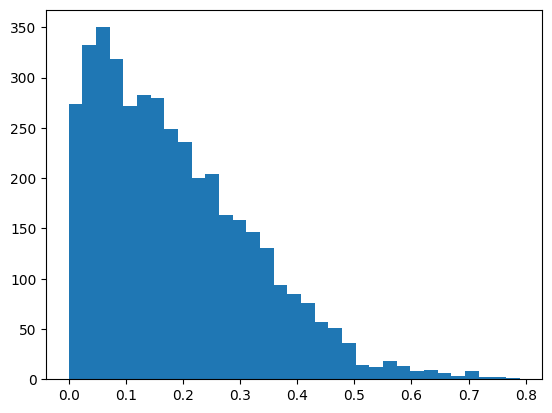

In [ ]:
import matplotlib.pyplot as plt
activations_corr = np.abs(corr[0][1:])
_ = plt.hist(activations_corr, bins='auto')

In [ ]:
activations_corr.shape

(4096,)

In [ ]:
print(model.classifier)


Sequential(
  (0): Dropout(p=0.5, inplace=False)
  (1): Linear(in_features=9216, out_features=4096, bias=True)
  (2): ReLU(inplace=True)
  (3): Dropout(p=0.5, inplace=False)
  (4): Linear(in_features=4096, out_features=4096, bias=True)
  (5): ReLU(inplace=True)
  (6): Linear(in_features=4096, out_features=2, bias=True)
)


In [ ]:
# Define the folder paths containing the original and patched images
original_folder_path = "/content/drive/MyDrive/Masterthesis/Datasets/ISIC_224/malignant_nopatch_224"
patched_folder_path = "/content/drive/MyDrive/Masterthesis/Datasets/ISIC_224/malignant_patched_224"

# Extract activations for all images in the original and patched folders
original_activations = process_images_in_folder(original_folder_path)
patched_activations = process_images_in_folder(patched_folder_path)

In [ ]:
def calculate_correlations(original_activations, patched_activations):
    # Convert activation lists to arrays
    original_activations_array = np.array(original_activations)
    patched_activations_array = np.array(patched_activations)

    # Ensure activations arrays have the correct shape
    original_activations_array = original_activations_array.reshape(len(original_activations_array), -1)
    patched_activations_array = patched_activations_array.reshape(len(patched_activations_array), -1)

    # Calculate correlations
    correlations = np.corrcoef(original_activations_array.T, patched_activations_array.T)

    # Extract correlations for each neuron
    neuron_correlations = correlations[:4096, 4096:]

    return neuron_correlations

# Calculate correlations for each neuron
neuron_correlations = calculate_correlations(original_activations, patched_activations)

# Print correlations for the first neuron as an example
print("Correlations for the first neuron:", neuron_correlations[0])

Correlations for the first neuron: [ 0.07240221 -0.00710556 -0.00525816 ... -0.00769213 -0.00429515
  0.01825639]
